In [158]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import re
import string

from langdetect import detect

from sklearn.feature_extraction.text import TfidfVectorizer

from nltk.sentiment.vader import SentimentIntensityAnalyzer
from collections import Counter
from scipy import stats
from dateutil import parser

import seaborn as sns

import shapely
from shapely.geometry import Point
import geopandas as gpd

In [83]:
%matplotlib inline

# Read in data

* `listings.csv`: includes description of listings, transit, if superhost... (95 cols)
* `reviews.csv`: includes listing id and unique id for each reviewer with comments, date

In [84]:
listings = pd.read_csv('./data/listings.csv')
reviews = pd.read_csv('./data/reviews.csv')

In [4]:
listings.head(3)

,id,listing_url,scrape_id,last_scraped,name,summary,space,description,experiences_offered,neighborhood_overview,...,review_scores_value,requires_license,license,jurisdiction_names,instant_bookable,cancellation_policy,require_guest_profile_picture,require_guest_phone_verification,calculated_host_listings_count,reviews_per_month
0,12147973,https://www.airbnb.com/rooms/12147973,20160906204935,2016-09-07,Sunny Bungalow in the City,"Cozy, sunny, family home. Master bedroom high...",The house has an open and cozy feel at the sam...,"Cozy, sunny, family home. Master bedroom high...",none,"Roslindale is quiet, convenient and friendly. ...",...,NaN,f,NaN,NaN,f,moderate,f,f,1,NaN
1,3075044,https://www.airbnb.com/rooms/3075044,20160906204935,2016-09-07,Charming room in pet friendly apt,Charming and quiet room in a second floor 1910...,Small but cozy and quite room with a full size...,Charming and quiet room in a second floor 1910...,none,"The room is in Roslindale, a diverse and prima...",...,9.0,f,NaN,NaN,t,moderate,f,f,1,1.30
2,6976,https://www.airbnb.com/rooms/6976,20160906204935,2016-09-07,Mexican Folk Art Haven in Boston,"Come stay with a friendly, middle-aged guy in ...","Come stay with a friendly, middle-aged guy in ...","Come stay with a friendly, middle-aged guy in ...",none,The LOCATION: Roslindale is a safe and diverse...,...,10.0,f,NaN,NaN,f,moderate,t,f,1,0.47


In [5]:
reviews.head(3)

,listing_id,id,date,reviewer_id,reviewer_name,comments
0,1178162,4724140,2013-05-21,4298113,Olivier,My stay at islam's place was really cool! Good...
1,1178162,4869189,2013-05-29,6452964,Charlotte,Great location for both airport and city - gre...
2,1178162,5003196,2013-06-06,6449554,Sebastian,We really enjoyed our stay at Islams house. Fr...


In [198]:
reviews['comments'][1]

'Great location for both airport and city - great amenities in the house: Plus Islam was always very helpful even though he was away'

# Preprocessing 'comments' for Sentiment Analysis

In [7]:
reviews.isnull().sum()

listing_id        0
id                0
date              0
reviewer_id       0
reviewer_name     0
comments         53
dtype: int64

In [8]:
reviews['comments'].str.match('The host canceled this reservation').sum()

743

> Few things we need to take care of:
* drop rows with null comments
* some reviews will also have the prototypical 'Host canceled this booking x days before', drop rows 
* misc preprocessing: remove numeric, -
* some reviews seem to be in other languages, have to detect the language and remove all non-English comments
    * langdetect module can do that for us
    
*NOTE: we're gonna keep capitalizations and punctuation because not only is it handled well with Vader, but it's also incorporated in the sentiment analysis (see below)*

In [85]:
reviews.dropna(subset =['comments'], how='any', axis=0, inplace=True)

index_canceled = reviews[ reviews['comments'].str.match('The host canceled this reservation')].index
reviews.drop(index_canceled, inplace=True)

index_dash = reviews[ reviews['comments'].str.match('-')].index
reviews.drop(index_dash, inplace=True)

alphanumeric = lambda x: re.sub('\w*\d\w*', ' ', x)
reviews['comments'] = reviews['comments'].map(alphanumeric)

#punc_lower = lambda x: re.sub('[%s]' % re.escape(string.punctuation), ' ', x.lower())
#reviews['comments'] = reviews['comments'].map(alphanumeric).map(punc_lower)

In [86]:
reviews.reset_index(inplace=True, drop=True)

In [87]:
num_errors = 0
err = []

for index, row in reviews.iterrows():
    try:
        language = detect(row['comments']) #(" ".join(row.split())) # row.strip())
    except:
        num_errors += 1
        err.append(index)
        print("This row throws an error:", row['comments'])

This row throws an error: .
This row throws an error: .
This row throws an error: 

This row throws an error: .
This row throws an error: ...
This row throws an error: .
This row throws an error: .
This row throws an error: .
This row throws an error: &
This row throws an error: . 
This row throws an error: .
This row throws an error:  / 
This row throws an error: :)
This row throws an error: .
This row throws an error: :-)


In [24]:
print('{:.2f}% of entries for language identification throw errors'.format(num_errors/reviews['comments'].shape[0] * 100))

0.02% of entries for language identification throw errors


> Seems to be due to empty entries with arbitrary number of white spaces and/or punctuations, drop those rows

In [ ]:
reviews.drop(err, axis=0, inplace=True)

In [90]:
reviews.reset_index(inplace=True, drop=True)

In [91]:
# and create new col 'language' with detected language
reviews['language'] = reviews['comments'].apply(detect)

In [32]:
reviews.head()

,listing_id,id,date,reviewer_id,reviewer_name,comments,language
0,1178162,4724140,2013-05-21,4298113,Olivier,my stay at islam s place was really cool good...,en
1,1178162,4869189,2013-05-29,6452964,Charlotte,great location for both airport and city gre...,en
2,1178162,5003196,2013-06-06,6449554,Sebastian,we really enjoyed our stay at islams house fr...,en
3,1178162,5150351,2013-06-15,2215611,Marine,the room was nice and clean and so were the co...,en
4,1178162,5171140,2013-06-16,6848427,Andrew,great location just mins walk from the airp...,en


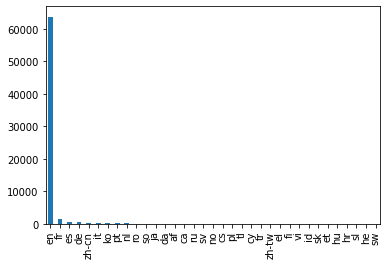

In [92]:
reviews['language'].value_counts().plot.bar();

In [93]:
# create a copy in case we eventually want to try translating the non-English rows instead of dropping them
reviews_en = reviews.copy(deep=True)

# isolate all non-en entries
index_nonen = reviews_en[~reviews_en['language'].str.match('en')].index

print('{:.2f}% of all entries are not in English'.format(len(index_nonen)/reviews_en.shape[0]))

0.06% of all entries are not in English


In [94]:
# drop
reviews_en.drop(index_nonen, inplace=True)

# Compute IDF values (Inverse Document Frequency)

Note: didn't end up using

most popular and widely adopted word weighing scheme in text mining problems, known as term frequency and inverse document frequency (tf-idf)

In [56]:
# Tfidfvectorizer computes word counts, idf and tf-idf values all at once
 
# compute IDF values (Inverse Document Frequency), weight assigned to each word depending on how commonly used
vectorizer = TfidfVectorizer(min_df=53, max_features=50, stop_words='english', ngram_range=(1,1), use_idf=True)
matrix = vectorizer.fit_transform(reviews_en['comments'])

In [60]:
# see first vector, IDF values for first comment

pd.DataFrame(matrix[0].T.todense(), index=vectorizer.get_feature_names(), 
             columns=["tfidf"]).sort_values(['tfidf'], ascending=False).style.bar(subset=['tfidf'], color=['#5fba7d'])


,tfidf
place,0.643540
airbnb,0.376996
good,0.302881
really,0.301737
room,0.253072
nice,0.252553
location,0.220070
clean,0.217474
stay,0.193376
quiet,0.000000


In [58]:
# and corresponding comment
reviews_en['comments'][0]

'my stay at islam s place was really cool  good location    away from subway  then   from downtown  the room was nice  all place was clean  islam managed pretty well our arrival  even if it was last minute    i do recommand this place to any airbnb user   '

# Estimate polarity 

https://medium.com/analytics-vidhya/simplifying-social-media-sentiment-analysis-using-vader-in-python-f9e6ec6fc52f

**VADER** (Valence Aware Dictionary and sEntiment Reasoner) is a lexicon and rule-based sentiment analysis tool that is specifically attuned to sentiments expressed in social media. VADER uses a combination of A sentiment lexicon is a list of lexical features (e.g., words) which are generally labelled according to their semantic orientation as either positive or negative.

VADER has been found to be quite successful when dealing with social media texts, NY Times editorials, movie reviews, and product reviews. This is because VADER not only tells about the Positivity and Negativity score but also tells us about how positive or negative a sentiment is.


Vader adds valence to words capitalized, with punctuation (ex compound score increases with number of exclamation points!), with degree modiferes (ex. very good vs good), emojis, and handles conjunctions (... but ... -> shifts in sentiment polarity) 

In [63]:
import nltk
nltk.download('vader_lexicon')

[nltk_data] Downloading package vader_lexicon to
[nltk_data]     /Users/alexandra/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


True

In [95]:
analyzer = SentimentIntensityAnalyzer()

In [96]:
# test it out on first comment

def sentiment_analyzer_scores(comment):
    score = analyzer.polarity_scores(comment)
    return(pd.DataFrame.from_dict(score, orient='index'))

sentiment_analyzer_scores(reviews_en['comments'][0])

,0
neg,0.0000
neu,0.6360
pos,0.3640
compound,0.9626


In [97]:
# we want one overall polarity score, so just look at the 'compound' score

polarity_compound = lambda s: (analyzer.polarity_scores(s))['compound']

In [98]:
reviews_en['polarity'] = reviews_en.comments.map(polarity_compound)

In [104]:
reviews_en[:5].style.bar(subset=['polarity'], align='mid', color=['#d65f5f', '#5fba7d'])

,listing_id,id,date,reviewer_id,reviewer_name,comments,language,polarity
0,1178162,4724140,2013-05-21,4298113,Olivier,"My stay at islam's place was really cool! Good location, away from subway, then from downtown. The room was nice, all place was clean. Islam managed pretty well our arrival, even if it was last minute ;) i do recommand this place to any airbnb user :)",en,0.962600
1,1178162,4869189,2013-05-29,6452964,Charlotte,Great location for both airport and city - great amenities in the house: Plus Islam was always very helpful even though he was away,en,0.906100
2,1178162,5003196,2013-06-06,6449554,Sebastian,We really enjoyed our stay at Islams house. From the outside the house didn't look so inviting but the inside was very nice! Even though Islam himself was not there everything was prepared for our arrival. The airport T Station is only a - min walk away. The only little issue was that all the people in the house had to share one bathroom. But it was not really a problem and it worked out fine. We would recommend Islams place for a stay in Boston.,en,0.966300
3,1178162,5150351,2013-06-15,2215611,Marine,The room was nice and clean and so were the commodities. Very close to the airport metro station and located in quite safe area. Islam responds very quickly and is very helpful. I would recommend it.,en,0.926700
4,1178162,5171140,2013-06-16,6848427,Andrew,"Great location. Just mins walk from the Airport Station. Good food nearby. Room was simple, clean, just what I was after.",en,0.865800


In [105]:
reviews_en[reviews_en['polarity']<0][:5].style.bar(subset=['polarity'], align='mid', color=['#d65f5f', '#5fba7d'])

,listing_id,id,date,reviewer_id,reviewer_name,comments,language,polarity
15,1178162,11069185,2014-03-18,10454265,Jeffrey,"The room was exactly as pictured, no frills, yet adequate for my needs. The street parking was nearly impossible to find, but you can't expect much better in Boston. I'd recommend this room to others...",en,-0.002300
17,1178162,11420562,2014-04-01,6097987,Karthikram,Izzy was great... had clear instructions and no problems entering the house... the neighborhood wasn't great though.,en,-0.680200
24,1178162,12753057,2014-05-10,14113353,Chris,We didn´t meet Izzy at all!!!! After we arrived nobody was there except some spanish speaking people. Our room was disgusting!!! It smelted like mold and was very dirty!!!! The Bathroom wasn´t cleaned either and my friend and i wanted to leave right after we came… The Dryer or washer was not usable because the assistant from Izzy washed all the time. The Neighborhood is not safe at all and every other morning u could hear people fight. Don´t stay there!!!!!! It´s nothing like u would expect it! And it´s defenetly to expensive for this nasty place!!!!,en,-0.779800
58,1178162,21219502,2014-10-13,1822593,Alexa,"The house was in a very convenient location to the airport (we walked to the shuttle) and the bed/room was clean. Not a great neighborhood, but again it was booked to be close to our early morning flight.",en,-0.076500
64,1178162,21809402,2014-10-24,22554506,Claude,"Parking situation was bad. Very hard to find a spot. :-( So if you are driving I don't recommend. On the positive side of things, the place was very clean and close to the airport.",en,-0.298200


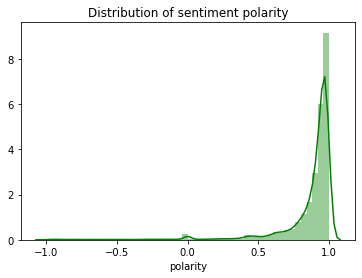

In [208]:
sns.distplot(reviews_en['polarity'], norm_hist=True, color='g')
plt.title('Distribution of sentiment polarity');

In [106]:
reviews_en.to_csv('reviews_en_polarity.csv', index=False)

# Explore polarity variable and correlation with other features, ex scores

Select from `listings.csv` all the columns with individual (accuracy, cleanliness, checkin, communication, location, & value) and overall (rating) scores. Include 'id' column to merge with other DataFrames, and neighbourhood for later analysis.

In [147]:
sel_listings = listings[['id', 'number_of_reviews', 'review_scores_rating', 'review_scores_accuracy', 
                         'review_scores_cleanliness', 'review_scores_checkin', 
                         'review_scores_communication', 'review_scores_location', 'review_scores_value',
                         'neighbourhood_cleansed']]

>Multiple reviews per listing

In [243]:
sel_reviews.head(3)

,listing_id,reviewer_id,comments,polarity
0,1178162,4298113,My stay at islam's place was really cool! Good...,0.9626
1,1178162,6452964,Great location for both airport and city - gre...,0.9061
2,1178162,6449554,We really enjoyed our stay at Islams house. Fr...,0.9663


In [148]:
list_pol = pd.DataFrame(sel_reviews.groupby(['listing_id']).mean()['polarity'])

In [149]:
full = pd.merge(sel_listings, list_pol, left_on='id', right_on='listing_id', how='left')

In [150]:
full.head()

,id,number_of_reviews,review_scores_rating,review_scores_accuracy,review_scores_cleanliness,review_scores_checkin,review_scores_communication,review_scores_location,review_scores_value,neighbourhood_cleansed,polarity
0,12147973,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Roslindale,NaN
1,3075044,36,94.0,10.0,9.0,10.0,10.0,9.0,9.0,Roslindale,0.914953
2,6976,41,98.0,10.0,9.0,10.0,10.0,9.0,10.0,Roslindale,0.905349
3,1436513,1,100.0,10.0,10.0,10.0,10.0,10.0,10.0,Roslindale,0.950600
4,7651065,29,99.0,10.0,10.0,10.0,10.0,9.0,10.0,Roslindale,0.891327


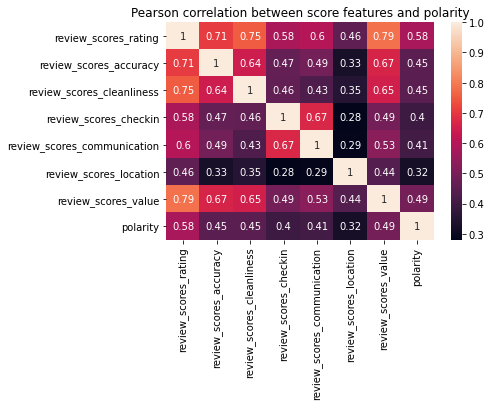

In [220]:
review_scores = ['review_scores_rating', 'review_scores_accuracy', 'review_scores_cleanliness', 
                 'review_scores_checkin', 'review_scores_communication', 'review_scores_location', 
                 'review_scores_value', 'polarity']

corr = full[review_scores].corr()

sns.heatmap(corr, annot=True)
plt.title('Pearson correlation between score features and polarity');

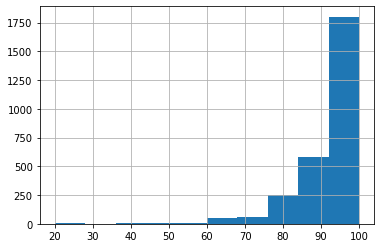

In [221]:
full['review_scores_rating'].hist();

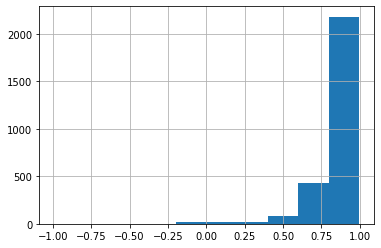

In [144]:
full['polarity'].hist();

## Explore by neighbourhood

In [159]:
# shape file of boston neighbourhoods (map)
boston_neighbourhoods = gpd.read_file('./data/Boston_Neighborhoods/Boston_Neighborhoods.shp')

In [189]:
listings_neighb = pd.DataFrame(full.groupby(['neighbourhood_cleansed']).mean())
listings_neighb.drop(['id'], axis=1, inplace=True)

In [177]:
listings_neighb

,number_of_reviews,review_scores_rating,review_scores_accuracy,review_scores_cleanliness,review_scores_checkin,review_scores_communication,review_scores_location,review_scores_value,polarity
neighbourhood_cleansed,,,,,,,,,
Allston,11.492308,90.164835,9.287293,8.989011,9.582418,9.598901,9.226519,9.049451,0.831311
Back Bay,14.533113,91.531646,9.334746,9.309322,9.555085,9.555085,9.949153,9.123404,0.848941
Bay Village,10.041667,93.000000,9.312500,9.250000,9.750000,9.812500,9.937500,9.125000,0.888747
Beacon Hill,21.123711,93.378698,9.446429,9.327381,9.779762,9.750000,9.934524,9.244048,0.878136
Brighton,16.497297,90.864662,9.383459,9.090226,9.646617,9.676692,9.278195,9.157895,0.806475
Charlestown,17.846847,93.697368,9.592105,9.434211,9.763158,9.828947,9.500000,9.368421,0.872093
Chinatown,9.422535,92.121951,9.365854,9.365854,9.439024,9.560976,9.292683,9.121951,0.821131
Dorchester,27.494424,89.280000,9.295964,8.982063,9.618834,9.607143,8.642857,9.049107,0.818016
Downtown,14.738372,92.432203,9.347458,9.406780,9.550847,9.533898,9.694915,9.152542,0.840518


In [233]:
listings_neighb.sort_values(['polarity'], ascending=False).head(3)

,number_of_reviews,review_scores_rating,review_scores_accuracy,review_scores_cleanliness,review_scores_checkin,review_scores_communication,review_scores_location,review_scores_value,polarity
neighbourhood_cleansed,,,,,,,,,
Leather District,13.800000,98.333333,10.000000,10.000000,10.000000,10.000000,9.333333,9.666667,0.930936
Roslindale,24.767857,95.380000,9.760000,9.660000,9.940000,9.940000,9.260000,9.580000,0.894791
Jamaica Plain,26.399417,94.159322,9.675768,9.413559,9.847458,9.836735,9.454237,9.450847,0.890678


In [234]:
listings_neighb.sort_values(['review_scores_location'], ascending=False).head(3)

,number_of_reviews,review_scores_rating,review_scores_accuracy,review_scores_cleanliness,review_scores_checkin,review_scores_communication,review_scores_location,review_scores_value,polarity
neighbourhood_cleansed,,,,,,,,,
Longwood Medical Area,43.666667,94.000000,9.666667,9.333333,9.666667,10.000000,10.000000,9.333333,0.659310
Back Bay,14.533113,91.531646,9.334746,9.309322,9.555085,9.555085,9.949153,9.123404,0.848941
North End,31.349650,93.725000,9.533333,9.316667,9.700000,9.766667,9.941667,9.325000,0.870848


In [190]:
boston_neighb = boston_neighbourhoods.merge(listings_neighb, left_on='Name', right_on='neighbourhood_cleansed')

In [191]:
boston_neighb

,OBJECTID,Name,Acres,Neighborho,SqMiles,ShapeSTAre,ShapeSTLen,geometry,number_of_reviews,review_scores_rating,review_scores_accuracy,review_scores_cleanliness,review_scores_checkin,review_scores_communication,review_scores_location,review_scores_value,polarity
0,27,Roslindale,1605.568237,15,2.51,6.993827e+07,53563.912597,"MULTIPOLYGON (((-71.12593 42.27201, -71.12575 ...",24.767857,95.380000,9.760000,9.660000,9.940000,9.940000,9.260000,9.580000,0.894791
1,28,Jamaica Plain,2519.245394,11,3.94,1.097379e+08,56349.937161,"POLYGON ((-71.10499 42.32610, -71.10488 42.326...",26.399417,94.159322,9.675768,9.413559,9.847458,9.836735,9.454237,9.450847,0.890678
2,29,Mission Hill,350.853564,13,0.55,1.528312e+07,17918.724113,"POLYGON ((-71.09043 42.33577, -71.09275 42.333...",11.846774,87.695122,9.246914,8.634146,9.358025,9.378049,9.100000,8.612500,0.784879
3,31,Bay Village,26.539839,33,0.04,1.156071e+06,4650.635493,"POLYGON ((-71.06663 42.34878, -71.06739 42.348...",10.041667,93.000000,9.312500,9.250000,9.750000,9.812500,9.937500,9.125000,0.888747
4,32,Leather District,15.639908,27,0.02,6.812717e+05,3237.140537,"POLYGON ((-71.05838 42.34983, -71.05877 42.349...",13.800000,98.333333,10.000000,10.000000,10.000000,10.000000,9.333333,9.666667,0.930936
5,33,Chinatown,76.324410,26,0.12,3.324678e+06,9736.590413,"POLYGON ((-71.05791 42.35238, -71.05796 42.352...",9.422535,92.121951,9.365854,9.365854,9.439024,9.560976,9.292683,9.121951,0.821131
6,34,North End,126.910439,14,0.20,5.527506e+06,16177.826815,"POLYGON ((-71.05200 42.36884, -71.05169 42.368...",31.349650,93.725000,9.533333,9.316667,9.700000,9.766667,9.941667,9.325000,0.870848
7,35,Roxbury,2108.469072,16,3.29,9.184455e+07,49488.800485,"POLYGON ((-71.09646 42.29323, -71.09662 42.293...",26.215278,89.803419,9.310345,9.119658,9.594828,9.495726,8.275862,8.948276,0.808054
8,36,South End,471.535356,32,0.74,2.054000e+07,17912.333569,"POLYGON ((-71.06834 42.34775, -71.06834 42.347...",17.527607,93.264925,9.520446,9.486989,9.717472,9.713755,9.720149,9.263941,0.864148
9,37,Back Bay,399.314411,2,0.62,1.739407e+07,19455.671146,"POLYGON ((-71.07569 42.35692, -71.07579 42.356...",14.533113,91.531646,9.334746,9.309322,9.555085,9.555085,9.949153,9.123404,0.848941


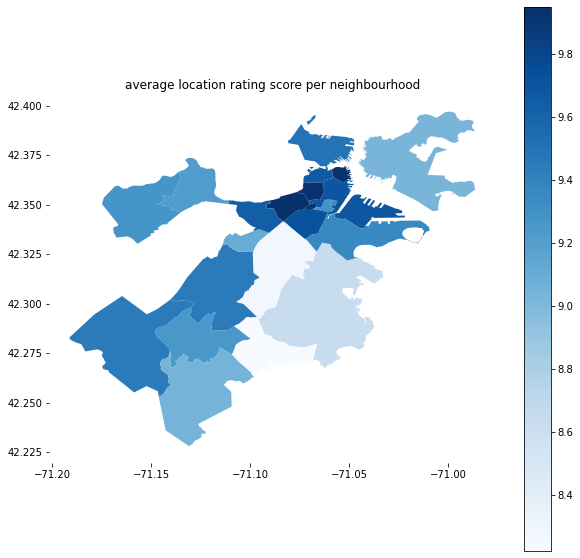

In [194]:
boston_neighb.plot(column='review_scores_location', cmap='Blues', figsize=(10,10), legend=True)
sns.despine(top=True, right=True, left=True, bottom=True)
plt.title('average location rating score per neighbourhood');

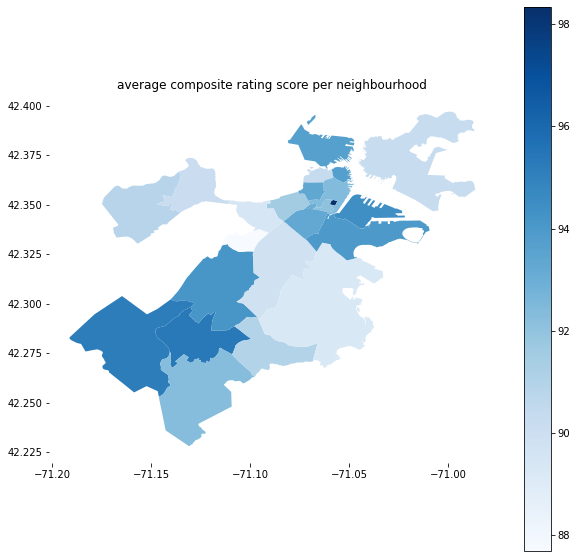

In [195]:
boston_neighb.plot(column='review_scores_rating', cmap='Blues', figsize=(10,10), legend=True)
sns.despine(top=True, right=True, left=True, bottom=True)
plt.title('average composite rating score per neighbourhood');

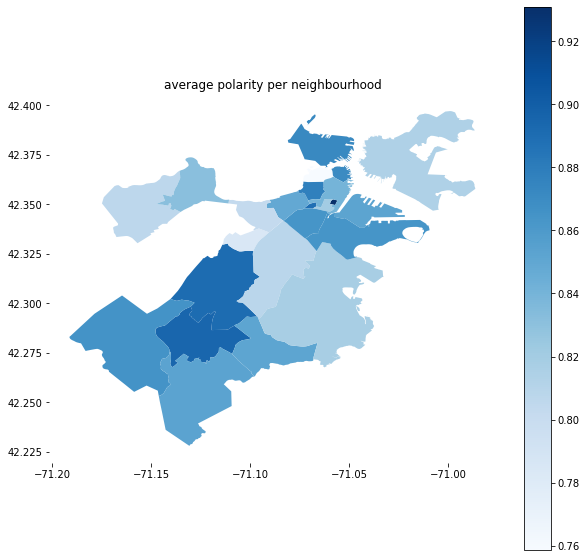

In [196]:
boston_neighb.plot(column='polarity', cmap='Blues', figsize=(10,10), legend=True)

sns.despine(top=True, right=True, left=True, bottom=True)
plt.title('average polarity per neighbourhood');

In [ ]:
boston_neighb['polarity_bin'] = pd.qcut(boston_neighb['polarity'], q=5, precision=2)

Text(0.5, 1.0, 'Average polarity per neighbourhood')

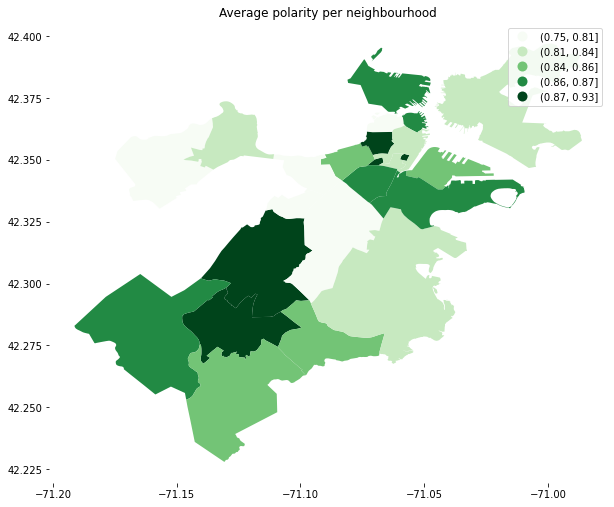

In [227]:
boston_neighb.plot(column='polarity_bin', cmap='Greens', figsize=(10,10), legend=True)

sns.despine(top=True, right=True, left=True, bottom=True)
plt.title('Average polarity per neighbourhood')


# Set up dataframe for dashboard

In [265]:
# drop rows with null polarity
full.dropna(subset = ['polarity'], how='any', axis=0, inplace=True)

full

,id,number_of_reviews,review_scores_rating,review_scores_accuracy,review_scores_cleanliness,review_scores_checkin,review_scores_communication,review_scores_location,review_scores_value,neighbourhood_cleansed,polarity
1,3075044,36,94.0,10.0,9.0,10.0,10.0,9.0,9.0,Roslindale,0.914953
2,6976,41,98.0,10.0,9.0,10.0,10.0,9.0,10.0,Roslindale,0.905349
3,1436513,1,100.0,10.0,10.0,10.0,10.0,10.0,10.0,Roslindale,0.950600
4,7651065,29,99.0,10.0,10.0,10.0,10.0,9.0,10.0,Roslindale,0.891327
5,12386020,8,100.0,10.0,10.0,10.0,10.0,9.0,10.0,Roslindale,0.959117
...,...,...,...,...,...,...,...,...,...,...,...
3573,14504583,2,80.0,9.0,10.0,9.0,9.0,10.0,10.0,Charlestown,0.483500
3575,5280827,6,70.0,8.0,7.0,9.0,10.0,8.0,7.0,Charlestown,0.524833
3578,14536322,2,100.0,10.0,10.0,10.0,10.0,10.0,10.0,Allston,0.830450
3580,8373729,4,90.0,10.0,10.0,10.0,10.0,8.0,9.0,Charlestown,0.811475


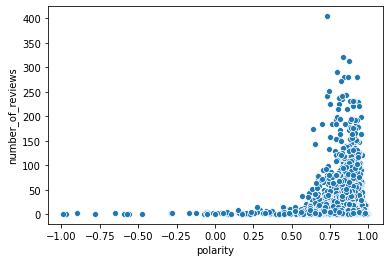

In [266]:
sns.scatterplot('polarity', 'number_of_reviews', data=full);

In [263]:
# selected columns from listings
dashboard_df = pd.DataFrame(listings[['id','price', 'security_deposit', 'cleaning_fee', 'guests_included', 'extra_people', 'minimum_nights',
               'maximum_nights', 'host_is_superhost']])

# remove $ sign
# and fill null values in security_deposit and cleaning_fee with 0
cols = ['price', 'security_deposit', 'cleaning_fee', 'extra_people']
for col in cols:
    dashboard_df[col] = dashboard_df[col].str.replace('$', '')
    dashboard_df[col].fillna(0, inplace=True)

# transform host_is_superhost to boolean 
dashboard_df.replace({'host_is_superhost': {'f': False, 't': True}}, inplace=True)

dashboard_df.head(3)

,id,price,security_deposit,cleaning_fee,guests_included,extra_people,minimum_nights,maximum_nights,host_is_superhost
0,12147973,250.00,0,35.00,1,0.00,2,1125,False
1,3075044,65.00,95.00,10.00,0,0.00,2,15,False
2,6976,65.00,0,0,1,20.00,3,45,True


In [267]:
dashboard_df = pd.merge(full, dashboard_df, left_on='id', right_on='id', how='left')

In [268]:
dashboard_df

,id,number_of_reviews,review_scores_rating,review_scores_accuracy,review_scores_cleanliness,review_scores_checkin,review_scores_communication,review_scores_location,review_scores_value,neighbourhood_cleansed,polarity,price,security_deposit,cleaning_fee,guests_included,extra_people,minimum_nights,maximum_nights,host_is_superhost
0,3075044,36,94.0,10.0,9.0,10.0,10.0,9.0,9.0,Roslindale,0.914953,65.00,95.00,10.00,0,0.00,2,15,False
1,6976,41,98.0,10.0,9.0,10.0,10.0,9.0,10.0,Roslindale,0.905349,65.00,0,0,1,20.00,3,45,True
2,1436513,1,100.0,10.0,10.0,10.0,10.0,10.0,10.0,Roslindale,0.950600,75.00,100.00,50.00,2,25.00,1,1125,False
3,7651065,29,99.0,10.0,10.0,10.0,10.0,9.0,10.0,Roslindale,0.891327,79.00,0,15.00,1,0.00,2,31,True
4,12386020,8,100.0,10.0,10.0,10.0,10.0,9.0,10.0,Roslindale,0.959117,75.00,0,30.00,1,0.00,2,1125,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2751,14504583,2,80.0,9.0,10.0,9.0,9.0,10.0,10.0,Charlestown,0.483500,65.00,0,25.00,1,30.00,1,1125,False
2752,5280827,6,70.0,8.0,7.0,9.0,10.0,8.0,7.0,Charlestown,0.524833,69.00,95.00,0,1,24.00,2,1125,False
2753,14536322,2,100.0,10.0,10.0,10.0,10.0,10.0,10.0,Allston,0.830450,85.00,0,0,1,0.00,1,1125,False
2754,8373729,4,90.0,10.0,10.0,10.0,10.0,8.0,9.0,Charlestown,0.811475,69.00,95.00,0,1,24.00,2,1125,False


In [269]:
# save dataframe as CSV

dashboard_df.to_csv('dashboard_df.csv', index=False)